<a href="https://colab.research.google.com/github/Mirand22/Results/blob/main/512%20-%201%20Dense%20Baseline_ADJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow as tf

In [2]:
url = "https://raw.githubusercontent.com/Mirand22/Results/main/ADJcsv.csv"

dataframe = pd.read_csv(url, usecols=[1]) 

In [6]:
dataframe.head()

,monitored_ns=4;s=OPC_IX_Durchflusssensor
0,0.000000
1,0.147375
2,0.294749
3,0.442124
4,0.589498


In [3]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #Convert values to float

In [4]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [5]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing


# split into train and test sets


train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size - int(len(dataset) * 0.15)
val_size = len(dataset) - train_size - test_size

train = dataset[0:train_size]
val = dataset[train_size:train_size+val_size]
test = dataset[train_size+val_size:len(dataset)]

In [8]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [9]:
seq_size = 512  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

In [10]:
trainX, trainY = to_sequences(train, seq_size)
valX, valY = to_sequences(val, seq_size)
testX, testY = to_sequences(test, seq_size)

In [11]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of val set: {}".format(valX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (315600, 512)
Shape of val set: (67226, 512)
Shape of test set: (67227, 512)


In [12]:
#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(256, input_dim=seq_size, activation='relu')) #12

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics = ['mse'])
print(model.summary()) 

Build deep model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
earlyStop = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=1, mode='auto', restore_best_weights=True)

In [14]:
# program to compute the time
# of execution of any python code
import time

# we initialize the variable start
# to store the starting time of
# execution of program
start = time.time()


history = model.fit(trainX, trainY, validation_data=(valX, valY),
          verbose=2, epochs=20, callbacks = [earlyStop])

# now we have initialized the variable
# end to store the ending time after
# execution of program
end = time.time()

# difference of start and end variables
# gives the time of execution of the
# program in between
print("The time of execution of above program is :", end-start)

Epoch 1/20
9863/9863 - 32s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.7308e-04 - val_mse: 5.7308e-04 - 32s/epoch - 3ms/step
Epoch 2/20
9863/9863 - 28s - loss: 4.6741e-04 - mse: 4.6741e-04 - val_loss: 5.2939e-04 - val_mse: 5.2939e-04 - 28s/epoch - 3ms/step
Epoch 3/20
9863/9863 - 22s - loss: 3.9977e-04 - mse: 3.9977e-04 - val_loss: 4.4113e-04 - val_mse: 4.4113e-04 - 22s/epoch - 2ms/step
Epoch 4/20
9863/9863 - 21s - loss: 3.5429e-04 - mse: 3.5429e-04 - val_loss: 4.2535e-04 - val_mse: 4.2535e-04 - 21s/epoch - 2ms/step
Epoch 5/20
Restoring model weights from the end of the best epoch: 1.
9863/9863 - 24s - loss: 3.2802e-04 - mse: 3.2802e-04 - val_loss: 4.3213e-04 - val_mse: 4.3213e-04 - 24s/epoch - 2ms/step
Epoch 5: early stopping
The time of execution of above program is : 127.87397336959839


In [15]:
# make predictions

trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

In [16]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 1.26 RMSE


In [18]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 1.38 RMSE


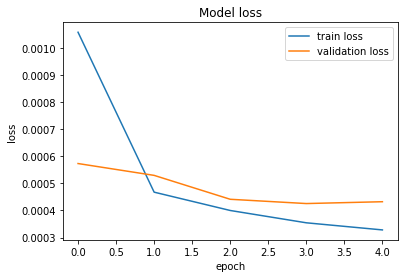

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()


In [20]:
from sklearn.metrics import r2_score


r2score = r2_score(testY[0], testPredict[:,0])
print("R^2 Score  = ",r2score)

R^2 Score  =  0.9873337733354708
